In [1]:
!unzip data.zip

Archive:  data.zip
   creating: data/cat/
  inflating: data/cat/_0_4015166.jpg  
  inflating: data/cat/_1_5346540.jpg  
  inflating: data/cat/_1_7703314.jpg  
  inflating: data/cat/_2_1600849.jpg  
  inflating: data/cat/_2_5883027.jpg  
  inflating: data/cat/_2_8900343.jpg  
  inflating: data/cat/_3_4674992.jpg  
  inflating: data/cat/_4_1244424.jpg  
   creating: data/dia/
  inflating: data/dia/100_left.jpeg  
  inflating: data/dia/100_right.jpeg  
  inflating: data/dia/102_left.jpeg  
  inflating: data/dia/102_right.jpeg  
  inflating: data/dia/108_left.jpeg  
  inflating: data/dia/108_right.jpeg  
  inflating: data/dia/111_left.jpeg  
   creating: data/gla/
  inflating: data/gla/_0_4517448.jpg  
  inflating: data/gla/_1_4540560.jpg  
  inflating: data/gla/_2_5194189.jpg  
  inflating: data/gla/_2_8820241.jpg  
  inflating: data/gla/_3_6499308.jpg  
  inflating: data/gla/_4_1717111.jpg  
  inflating: data/gla/_4_5317326.jpg  
   creating: data/nor/
  inflating: data/nor/530_left.jpg 

In [3]:
!pip list

Package                       Version
----------------------------- --------------------
absl-py                       1.4.0
aeppl                         0.0.33
aesara                        2.7.9
alabaster                     0.7.13
albumentations                1.2.1
altair                        4.2.2
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arviz                         0.12.1
astropy                       4.3.1
astunparse                    1.6.3
atomicwrites                  1.4.1
attrs                         22.2.0
audioread                     3.0.0
autograd                      1.5
Babel                         2.12.1
backcall                      0.2.0
backports.zoneinfo            0.2.1
beautifulsoup4                4.6.3
bleach                        6.0.0
blis                          0.7.9
bokeh                         2.4.3
branca                        0.6.0
bs4                           0.0.1
CacheControl                  0.12.11
cach

# Import Libraries

In [5]:
from google.colab import drive
drive.mount('d')

Mounted at d


First of all import these ibraries by hitting CTRL + ENTER

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
import tensorflow as tf
%matplotlib inline

In [7]:
import matplotlib
matplotlib.__version__

'3.5.3'

In [8]:
print(tf.__version__)

2.11.0


In [9]:
import tensorflow_hub as hub

In [10]:
import os

# Accessing files

This piece of code will access the folder containing the image files. Before running this code please mount the drive and set the path to the location where the file is stored.

In [11]:
path = '/content/data'
address = []
l1 = os.listdir(path)
for i in l1:
  l2 = os.listdir(path +'/'+ i)
  for n in l2:
    address.append([path+'/'+i+'/'+n,i])

This line turns the location and class of image into dataframe

In [12]:
df = pd.DataFrame(address,columns = ['address', 'group'])
df.head()

,address,group
0,/content/data/nor/530_right.jpg,nor
1,/content/data/nor/84_left.jpg,nor
2,/content/data/nor/695_right.jpg,nor
3,/content/data/nor/530_left.jpg,nor
4,/content/data/nor/84_right.jpg,nor


In [13]:
df['group'].value_counts()

nor    8
cat    8
gla    7
dia    7
Name: group, dtype: int64

This tells us how many images of different class are present.

# preprocessing

Axial image and its shape

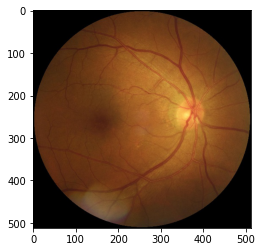

In [14]:
img = plt.imread(df['address'][0])
plt.imshow(img)

In [15]:
img.shape

(512, 512, 3)

This piece of code is for turning the categorical values to integer values.

In [16]:
df['label'] = df['group'].map({'cat': 1,  'nor' : 0 , 'dia' : 2,'gla': 3})

In [17]:
len(df)

30

In [18]:
df.head()

,address,group,label
0,/content/data/nor/530_right.jpg,nor,0
1,/content/data/nor/84_left.jpg,nor,0
2,/content/data/nor/695_right.jpg,nor,0
3,/content/data/nor/530_left.jpg,nor,0
4,/content/data/nor/84_right.jpg,nor,0


This will turn your label into boolean.


In [19]:
unique = np.unique(df['label'])
boolean_labels = [label == unique for label in df['label']]
boolean_labels[:2]

[array([ True, False, False, False]), array([ True, False, False, False])]

# Split test and train

In [20]:
X = df['address']
y = boolean_labels

In [21]:
NUM_IMAGES = len(df)

In [22]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X[:NUM_IMAGES],
                                                 y[:NUM_IMAGES], 
                                                 test_size = 0.20,
                                                 random_state =42,
                                                 shuffle =True,
                                                 stratify = y[:NUM_IMAGES])

In [23]:
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size = 0.20,random_state = 42)

In [24]:
len(X_train), len(X_val), len(X_test)

(19, 5, 6)

The size of image to be taken depends on the model you are training.
* For inception V3 the img_size = 299
* for mobileNetV2 the img_size = 224
* For Alzheinet it is 100.

In [25]:
img_size = 224
def process_images(image_path, img_size = img_size):

  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels = 3)
  img = tf.image.convert_image_dtype(img,tf.float32)
  img = tf.image.resize(img, size = [img_size,img_size])

  return img

In [26]:
def get_image_label(image_path, label):
  image = process_images(image_path)

  return image,label

In [27]:
tf.data.Dataset.from_tensor_slices(tf.constant(X_test))

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [28]:
batch_size = 32

def create_data_batches(X,y=None,batch_size=batch_size,valid_data=False,test_data=False):
  if test_data:
    print('Creating test data batches....')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
    data_batch = data.map(process_images).batch(batch_size)
    return data_batch

  elif valid_data:
    print('Creating valiation data batches....')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))
    data_batch = data.map(get_image_label).batch(batch_size)
    return data_batch

  else:
    print("Creating training data batches....")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))
    data = data.shuffle(buffer_size = len(X))
    data = data.map(get_image_label)
    data_batch = data.batch(batch_size)
  return data_batch

In [29]:
train_data = create_data_batches(X_train,y_train)
val_data = create_data_batches(X_val,y_val,valid_data = True)

Creating training data batches....
Creating valiation data batches....


In [30]:
test_data = create_data_batches(X_test,test_data = True)

Creating test data batches....


In [31]:
train_data.element_spec,val_data.element_spec,test_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 4), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 4), dtype=tf.bool, name=None)),
 TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None))

In [32]:
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.bool, name=None))>

# Eye disease

In [33]:
import numpy as np
import pandas as pd
from keras.layers import Dense, Flatten, Conv2D
from keras.layers import BatchNormalization, MaxPool2D, Dropout
from keras import Sequential

In [34]:
import keras

In [35]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.models import Model

## modelling

In [36]:
img_size = 224

input_size = [None,img_size,img_size,3]

output_size = len(unique)

model_url = 'https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/classification/5'


In [37]:
data_augmentation = keras.Sequential([
  keras.layers.RandomFlip("horizontal_and_vertical"),
  keras.layers.RandomRotation(0.4),
])

In [38]:
def create_model(input_size = input_size, output_size = output_size, model_url = model_url):
  model = tf.keras.Sequential([#data_augmentation,
                              hub.KerasLayer(model_url),
                              tf.keras.layers.Flatten(),
                              tf.keras.layers.Dense(units = 256,activation ='relu'),
                              tf.keras.layers.Dense(units = 256,activation ='relu'),
                              tf.keras.layers.Dense(units = output_size, activation ='softmax')])
  model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
  model.build(input_size)

  return model

In [39]:
model = create_model()
model.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              2052577   
                                                                 
 flatten (Flatten)           (None, 1001)              0         
                                                                 
 dense (Dense)               (None, 256)               256512    
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 2,375,909
Trainable params: 323,332
Non-trainable params: 2,052,577
_________________________________________________________________


In [40]:
%load_ext tensorboard

In [41]:
import datetime

def create_tensorboard_callback():

  logdir = os.path.join('/content/logs', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

  return tf.keras.callbacks.TensorBoard(logdir)

In [42]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                  patience = 3)

In [43]:
epoc =20 #@param {type:"slider", min:20,max:1000}

In [44]:
tensorboard = create_tensorboard_callback()

history = model.fit(x=train_data,
            epochs = epoc,
            validation_data = val_data,
            validation_freq = 1,
            callbacks = [tensorboard,early_stopping])

Epoch 1/20
1/1 [==============================] - 14s 14s/step - loss: 1.0178 - accuracy: 0.0526 - val_loss: 0.3852 - val_accuracy: 0.4000
Epoch 2/20
1/1 [==============================] - 0s 99ms/step - loss: 0.3811 - accuracy: 0.7895 - val_loss: 0.1887 - val_accuracy: 1.0000
Epoch 3/20
1/1 [==============================] - 0s 103ms/step - loss: 0.2184 - accuracy: 0.9474 - val_loss: 0.0997 - val_accuracy: 1.0000
Epoch 4/20
1/1 [==============================] - 0s 99ms/step - loss: 0.1169 - accuracy: 0.9474 - val_loss: 0.0677 - val_accuracy: 1.0000
Epoch 5/20
1/1 [==============================] - 0s 113ms/step - loss: 0.0739 - accuracy: 1.0000 - val_loss: 0.0465 - val_accuracy: 1.0000


In [49]:
model.save('/content/drive/MyDrive/model/mobilenet.h5')

In [51]:
model = tf.keras.models.load_model('/content/drive/MyDrive/model/mobilenet.h5',custom_objects={'KerasLayer': hub.KerasLayer})

In [52]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model.tflite','wb') as f:
  f.write(tflite_model)

In [53]:
y_preds = model.predict(test_data,verbose = 1)

1/1 [==============================] - 1s 1s/step


In [54]:
model.predict(process_images('/content/data/cat/_0_4015166.jpg'))

InvalidArgumentError: ignored

In [55]:
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique[np.argmax(prediction_probabilities)]

In [56]:
HEcustom_pred_labels = [get_pred_label(y_preds[i]) for i in range(len(y_preds))]

In [57]:
custom_test = [get_pred_label(y_test[i]) for i in range(len(y_test))]

In [58]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

In [62]:
confusion_matrix(custom_test, HEcustom_pred_labels)

array([[2, 0, 0, 0],
       [1, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])

In [64]:
print(accuracy_score(custom_test,HEcustom_pred_labels))
print(precision_score(custom_test,HEcustom_pred_labels,average = None))
print(recall_score(custom_test,HEcustom_pred_labels, average = None))

0.8333333333333334
[0.66666667 1.         1.         1.        ]
[1.  0.5 1.  1. ]
